In [21]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [492]:
import metroscore.network_builder as mnb
import metroscore.service_areas as msa
import metroscore.utils as mu
import folium
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import partridge as ptg

%config InlineBackend.figure_format = 'retina'

In [189]:
mta_subway_feed = mnb.load_gtfs_feed("../data/google_transit.zip")
nyc_bike = ox.graph_from_place(
    "Manhattan, New York, USA", 
    retain_all=False, 
    truncate_by_edge=True, 
    simplify=True, 
    network_type='bike'
)
nyc_bike = ox.project_graph(nyc_bike)
nyc_bike = ox.add_edge_speeds(nyc_bike)
nyc_bike = ox.add_edge_travel_times(nyc_bike)

In [360]:
node_gdf, edge_gdf, combined = mnb.build_edge_and_node_gdf(mta_subway_feed)

In [160]:
unionsq = (
    mta_subway_feed.stops
    .loc[mta_subway_feed.stops['stop_name'].str.contains('Union Sq')]
    .drop(columns=['parent_station', 'location_type'])
    .set_index("stop_id")
    .to_crs(3857)
)
_103st = (
    mta_subway_feed.stops
    .loc[mta_subway_feed.stops['stop_name'] == '103 St']
    .drop(columns=['parent_station', 'location_type'])
    .set_index("stop_id")
    .to_crs(3857)
)
_103st

stop_name                          geometry
stop_id                                            
119N       103 St  POINT (-8234122.285 4982804.849)
119S       103 St  POINT (-8234122.285 4982804.849)
624N       103 St  POINT (-8231795.596 4981504.103)
624S       103 St  POINT (-8231795.596 4981504.103)
A18N       103 St  POINT (-8233351.398 4982311.645)
A18S       103 St  POINT (-8233351.398 4982311.645)

In [161]:
mnb._dedupe_per_stop_name(_103st, tol=180)

stop_name                          geometry deduped_stops
stop_id                                                          
119N       103 St  POINT (-8234122.285 4982804.849)        {119S}
624N       103 St  POINT (-8231795.596 4981504.103)        {624S}
A18N       103 St  POINT (-8233351.398 4982311.645)        {A18S}

In [162]:
unionsq

stop_name                          geometry
stop_id                                                  
635N     14 St-Union Sq  POINT (-8236523.669 4973284.413)
635S     14 St-Union Sq  POINT (-8236523.669 4973284.413)
L03N     14 St-Union Sq  POINT (-8236610.387 4973301.454)
L03S     14 St-Union Sq  POINT (-8236610.387 4973301.454)
R20N     14 St-Union Sq  POINT (-8236592.353 4973440.579)
R20S     14 St-Union Sq  POINT (-8236592.353 4973440.579)

In [163]:
mnb._dedupe_per_stop_name(unionsq, tol=180)

stop_name                          geometry  \
stop_id                                                     
635N     14 St-Union Sq  POINT (-8236523.669 4973284.413)   

                          deduped_stops  
stop_id                                  
635N     {R20N, R20S, 635S, L03S, L03N}

In [353]:
deduplicated_stops, mapping = mnb.deduplicate_stops(
    mta_subway_feed.stops[['stop_id', 'stop_name', 'geometry']].set_index("stop_id").to_crs(3857), 
    tol=500
)
deduplicated_stops

stop_name                          geometry
stop_id                                                       
L06N                    1 Av  POINT (-8235597.157 4972737.923)
119N                  103 St  POINT (-8234122.285 4982804.849)
624N                  103 St  POINT (-8231795.596 4981504.103)
A18N                  103 St  POINT (-8233351.398 4982311.645)
706N     103 St-Corona Plaza  POINT (-8222358.153 4975516.524)
...                      ...                               ...
J15N          Woodhaven Blvd  POINT (-8221119.835 4967293.204)
401N                Woodlawn  POINT (-8224144.942 4995546.652)
E01N      World Trade Center  POINT (-8238731.135 4970039.563)
F18N                 York St  POINT (-8236167.447 4968397.059)
606N               Zerega Av  POINT (-8220614.444 4988253.515)

[448 rows x 2 columns]

In [354]:
deduplicated_stops.query("""stop_name == '103 St'""")

stop_name                          geometry
stop_id                                            
119N       103 St  POINT (-8234122.285 4982804.849)
624N       103 St  POINT (-8231795.596 4981504.103)
A18N       103 St  POINT (-8233351.398 4982311.645)

In [361]:
node_gdf

stop_name                    geometry          x          y
stop_id                                                                       
L06N                    1 Av  POINT (-73.98163 40.73095) -73.981628  40.730953
119N                  103 St  POINT (-73.96838 40.79945) -73.968379  40.799446
624N                  103 St  POINT (-73.94748 40.79060) -73.947478  40.790600
A18N                  103 St  POINT (-73.96145 40.79609) -73.961454  40.796092
706N     103 St-Corona Plaza  POINT (-73.86270 40.74987) -73.862700  40.749865
...                      ...                         ...        ...        ...
J15N          Woodhaven Blvd  POINT (-73.85158 40.69388) -73.851576  40.693879
401N                Woodlawn  POINT (-73.87875 40.88604) -73.878751  40.886037
E01N      World Trade Center  POINT (-74.00978 40.71258) -74.009781  40.712582
F18N                 York St  POINT (-73.98675 40.70140) -73.986751  40.701397
606N               Zerega Av  POINT (-73.84704 40.83649) -73.847036  40.836488

[465 rows x 4 columns]

In [362]:
subway_network = ox.graph_from_gdfs(node_gdf, edge_gdf)
subway_network = ox.project_graph(subway_network)
# subway_network = ox.consolidate_intersections(subway_network, tolerance=250)

In [363]:
len(subway_network.nodes), len(nyc_bike.nodes)

(465, 7142)

In [364]:
m = ox.graph_to_gdfs(subway_network, nodes=False, edges=True).explore(name="Routes")
m = ox.graph_to_gdfs(subway_network, nodes=True, edges=False).explore(m=m, color='red', radius=50, name="Stops")

folium.LayerControl().add_to(m)

# m.save('nyc_subway_network.html')

m

In [307]:
# save ox graph
filepath = "./nyc_subway_approxshapes.graphml"
ox.save_graphml(subway_network, filepath)

In [310]:
timetable = msa.make_timetable(
    mta_subway_feed.stop_times.assign(
        stop_id=combined["stop_id"].map(lambda x: mapping.get(x, x)),
    )
)
timetable

from  to  
101N  103N    [390.0, 1530.0, 2730.0, 3930.0, 5130.0, 6330.0...
103N  101N    [7830.0, 9030.0, 10230.0, 11430.0, 12630.0, 13...
      104N    [480.0, 1620.0, 2820.0, 4020.0, 5220.0, 6420.0...
104N  103N    [7530.0, 8730.0, 9930.0, 11130.0, 12330.0, 135...
      106N    [570.0, 1710.0, 2910.0, 4110.0, 5310.0, 6510.0...
                                    ...                        
S29N  S30N    [5880.0, 7680.0, 9480.0, 11280.0, 13080.0, 148...
S30N  S29N    [540.0, 2340.0, 4140.0, 5940.0, 7740.0, 9540.0...
      S31N    [6000.0, 7800.0, 9600.0, 11400.0, 13200.0, 150...
S31N  S19N    [25260.0, 26160.0, 27060.0, 27960.0, 28860.0, ...
      S30N    [360.0, 2160.0, 3960.0, 5760.0, 7560.0, 9360.0...
Length: 1119, dtype: object

## Adding Bus Network

In [365]:
mta_manhattan_bus_feed = mnb.load_gtfs_feed("../data/google_transit_manhattan.zip")

In [539]:
bus_node_gdf, bus_edge_gdf, bus_stop_mapping = mnb.build_edge_and_node_gdf(mta_manhattan_bus_feed)

In [540]:
bus_network = ox.graph_from_gdfs(bus_node_gdf, bus_edge_gdf)

In [541]:
len(bus_network.nodes()), len(bus_network.edges())

(1455, 2010)

In [542]:
m = ox.graph_to_gdfs(bus_network, nodes=False, edges=True).explore(name="Routes")
m = ox.graph_to_gdfs(bus_network, nodes=True, edges=False).explore(m=m, color='red', radius=50, name="Stops")

folium.LayerControl().add_to(m)

# m.save('nyc_subway_network.html')

m

In [543]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    bike_and_subway = mu.merge_graphs(a=subway_network, other=bus_network, tol=500)

('109N', {'stop_name': 'Dyckman St', 'x': -8229353.024139811, 'y': 4991791.732193455, 'lon': -73.92553599999998, 'lat': 40.860531}) ('405091', {'stop_name': 'FORT GEORGE AV/66 FORT GEORGE AV', 'x': -8229473.026550888, 'y': 4991402.57289241, 'lon': -73.92661399999999, 'lat': 40.857887})
('109N', '405091', {'geometry': <LINESTRING (-8229353.024 4991791.732, -8229473.027 4991402.573)>, 'length': 0.0, 'joined': True, 'travel_time': 0.0})
('110N', {'stop_name': '191 St', 'x': -8229784.498486129, 'y': 4991010.7799382275, 'lon': -73.929412, 'lat': 40.855225000000004}) ('400449', {'stop_name': 'SAINT NICHOLAS AV/W 190 ST', 'x': -8229854.295806854, 'y': 4990903.194169918, 'lon': -73.93003899999998, 'lat': 40.85449400000001})
('110N', '400449', {'geometry': <LINESTRING (-8229784.498 4991010.78, -8229854.296 4990903.194)>, 'length': 0.0, 'joined': True, 'travel_time': 0.0})
('111N', {'stop_name': '181 St', 'x': -8230250.2592356065, 'y': 4990168.964034763, 'lon': -73.933596, 'lat': 40.849505}) ('4

In [544]:
bike_and_subway['L08N']

AdjacencyView({'L06N': {0: {'length': 0.028269325018469203, 'travel_time': 210.0, 'geometry': <LINESTRING (-8232841.332 4970733.067, -8235597.157 4972737.923)>}}, 'L10N': {0: {'length': 0.007350135372900439, 'travel_time': 180.0, 'geometry': <LINESTRING (-8232841.332 4970733.067, -8232106.957 4970257.067)>}}})

In [545]:
subway_network.get_edge_data('L11N', 'L12N')

{0: {'length': 0.0042905722229100475, 'travel_time': 90.0}}

In [548]:
bus_timetable = msa.make_timetable(
    mta_manhattan_bus_feed.stop_times.assign(
        stop_id=combined["stop_id"].map(lambda x: mapping.get(x, x)),
    )
)
bus_timetable

from    to    
101014  101015    [4680.0, 8280.0, 11880.0, 15480.0, 17280.0, 19...
        101074    [2100.0, 5700.0, 9300.0, 12900.0, 14700.0, 165...
101015  101017    [4746.0, 8346.0, 11946.0, 15546.0, 17346.0, 19...
101017  101018    [4842.0, 8442.0, 12042.0, 15642.0, 17442.0, 19...
        101071    [1980.0, 5580.0, 9180.0, 12780.0, 14580.0, 163...
                                        ...                        
903318  803239    [19714.0, 20554.0, 21274.0, 21994.0, 22714.0, ...
903323  402460    [19200.0, 20040.0, 20760.0, 21480.0, 22200.0, ...
904041  403805    [5340.0, 8040.0, 10680.0, 13380.0, 16080.0, 18...
904242  503853    [7794.0, 9391.0, 11191.0, 12391.0, 13591.0, 14...
904246  804142    [7437.0, 9077.0, 10877.0, 12077.0, 13277.0, 14...
Length: 2010, dtype: object

In [595]:
pd.concat([None, bus_timetable])

from    to    
101014  101015    [4680.0, 8280.0, 11880.0, 15480.0, 17280.0, 19...
        101074    [2100.0, 5700.0, 9300.0, 12900.0, 14700.0, 165...
101015  101017    [4746.0, 8346.0, 11946.0, 15546.0, 17346.0, 19...
101017  101018    [4842.0, 8442.0, 12042.0, 15642.0, 17442.0, 19...
        101071    [1980.0, 5580.0, 9180.0, 12780.0, 14580.0, 163...
                                        ...                        
903318  803239    [19714.0, 20554.0, 21274.0, 21994.0, 22714.0, ...
903323  402460    [19200.0, 20040.0, 20760.0, 21480.0, 22200.0, ...
904041  403805    [5340.0, 8040.0, 10680.0, 13380.0, 16080.0, 18...
904242  503853    [7794.0, 9391.0, 11191.0, 12391.0, 13591.0, 14...
904246  804142    [7437.0, 9077.0, 10877.0, 12077.0, 13277.0, 14...
Length: 2010, dtype: object

In [551]:
full_timetable = pd.concat([timetable, bus_timetable])

In [570]:
sp = msa.time_dependent_djikstra(
    G=bike_and_subway,
    timetable=full_timetable,
    start_time=0,
    origin_id="L11N"
)

In [571]:
import networkx as nx

In [572]:
sp

{'101N': 13890.0,
 '103N': 13710.0,
 '104N': 12480.0,
 '106N': 12240.0,
 '107N': 12120.0,
 '108N': 12060.0,
 '109N': 10800.0,
 '110N': 10710.0,
 '111N': 10620.0,
 '112N': 10500.0,
 '113N': 10410.0,
 '114N': 10290.0,
 '115N': 9030.0,
 '116N': 8880.0,
 '117N': 8760.0,
 '118N': 7530.0,
 '119N': 7440.0,
 '120N': 6840.0,
 '121N': 7470.0,
 '227N': 7170.0,
 '123N': 5910.0,
 '122N': 7200.0,
 '226N': 8400.0,
 '124N': 5820.0,
 '127N': 5460.0,
 '225N': 8490.0,
 '125N': 5730.0,
 '128N': 5370.0,
 '126N': 5580.0,
 '901N': 7185.0,
 'D17N': 5670.0,
 'R15N': 9180.0,
 'R14N': 9390.0,
 '726N': 5700.0,
 '724N': 6030.0,
 'A25N': 6210.0,
 'A22N': 13110.0,
 'A27N': 7140.0,
 'A15N': 11070.0,
 'D14N': 5970.0,
 '129N': 5310.0,
 '132N': 3963.0,
 'A32N': 5640.0,
 'D16N': 7440.0,
 'D18N': 6450.0,
 'R18N': 5970.0,
 '635N': 2490.0,
 'R13N': 8760.0,
 'B08N': 9540.0,
 '631N': 6120.0,
 'A21N': 13200.0,
 'A28N': 7140.0,
 'A16N': 11250.0,
 'A14N': 13500.0,
 'A12N': 12390.0,
 'D15N': 7290.0,
 'F12N': 6330.0,
 'A20N': 1281

In [573]:
travel_times_from_L11N = dict(map(lambda x: (x[0], x[1] - 25200),filter(lambda x: x[1] != np.inf, sp.items())))

nx.set_node_attributes(
    bike_and_subway, 
    travel_times_from_L11N | {n: None for n in set(bike_and_subway.nodes) - set(travel_times_from_L11N.keys())},
    name='travel_time_from_L11N',
    
)

node_colors = ox.plot.get_node_colors_by_attr(bike_and_subway, 'travel_time_from_L11N', cmap='cool', na_color='white')

In [574]:
node_colors.shape

(1920,)

In [575]:
ox.graph_to_gdfs(bus_network, edges=False)

stop_name          x          y                    geometry
osmid                                                                       
450222     W 18 ST / 10 AV -74.005938  40.744323  POINT (-74.00594 40.74432)
401507        9 AV/W 18 ST -74.003816  40.743200  POINT (-74.00382 40.74320)
404286   W 14 ST/HUDSON ST -74.004803  40.740620  POINT (-74.00480 40.74062)
401575        W 14 ST/8 AV -74.002394  40.739621  POINT (-74.00239 40.73962)
401294        W 14 ST/7 AV -73.999271  40.738287  POINT (-73.99927 40.73829)
...                    ...        ...        ...                         ...
402330     YORK AV/E 63 ST -73.957570  40.761483  POINT (-73.95757 40.76148)
402331     YORK AV/E 66 ST -73.956240  40.763333  POINT (-73.95624 40.76333)
402336     YORK AV/E 76 ST -73.951606  40.769679  POINT (-73.95161 40.76968)
904918  EAST 92 ST/YORK AV -73.944774  40.779873  POINT (-73.94477 40.77987)
405359   PIKE ST/SOUTH  ST -73.991893  40.710615  POINT (-73.99189 40.71061)

[1455 rows x 4 columns]

In [576]:
max_time = max(filter(lambda x: x is not None, nx.get_node_attributes(bike_and_subway, 'travel_time_from_L11N').values()))
max_time

57108.0

In [577]:
from matplotlib.cm import ScalarMappable

In [578]:
m = ox.graph_to_gdfs(bike_and_subway, nodes=False, edges=True).explore(name="Routes")
m = ox.graph_to_gdfs(bike_and_subway, nodes=True, edges=False).explore(m=m, color='red', radius=50, name="Stops")

folium.LayerControl().add_to(m)

# m.save('nyc_subway_network.html')

m

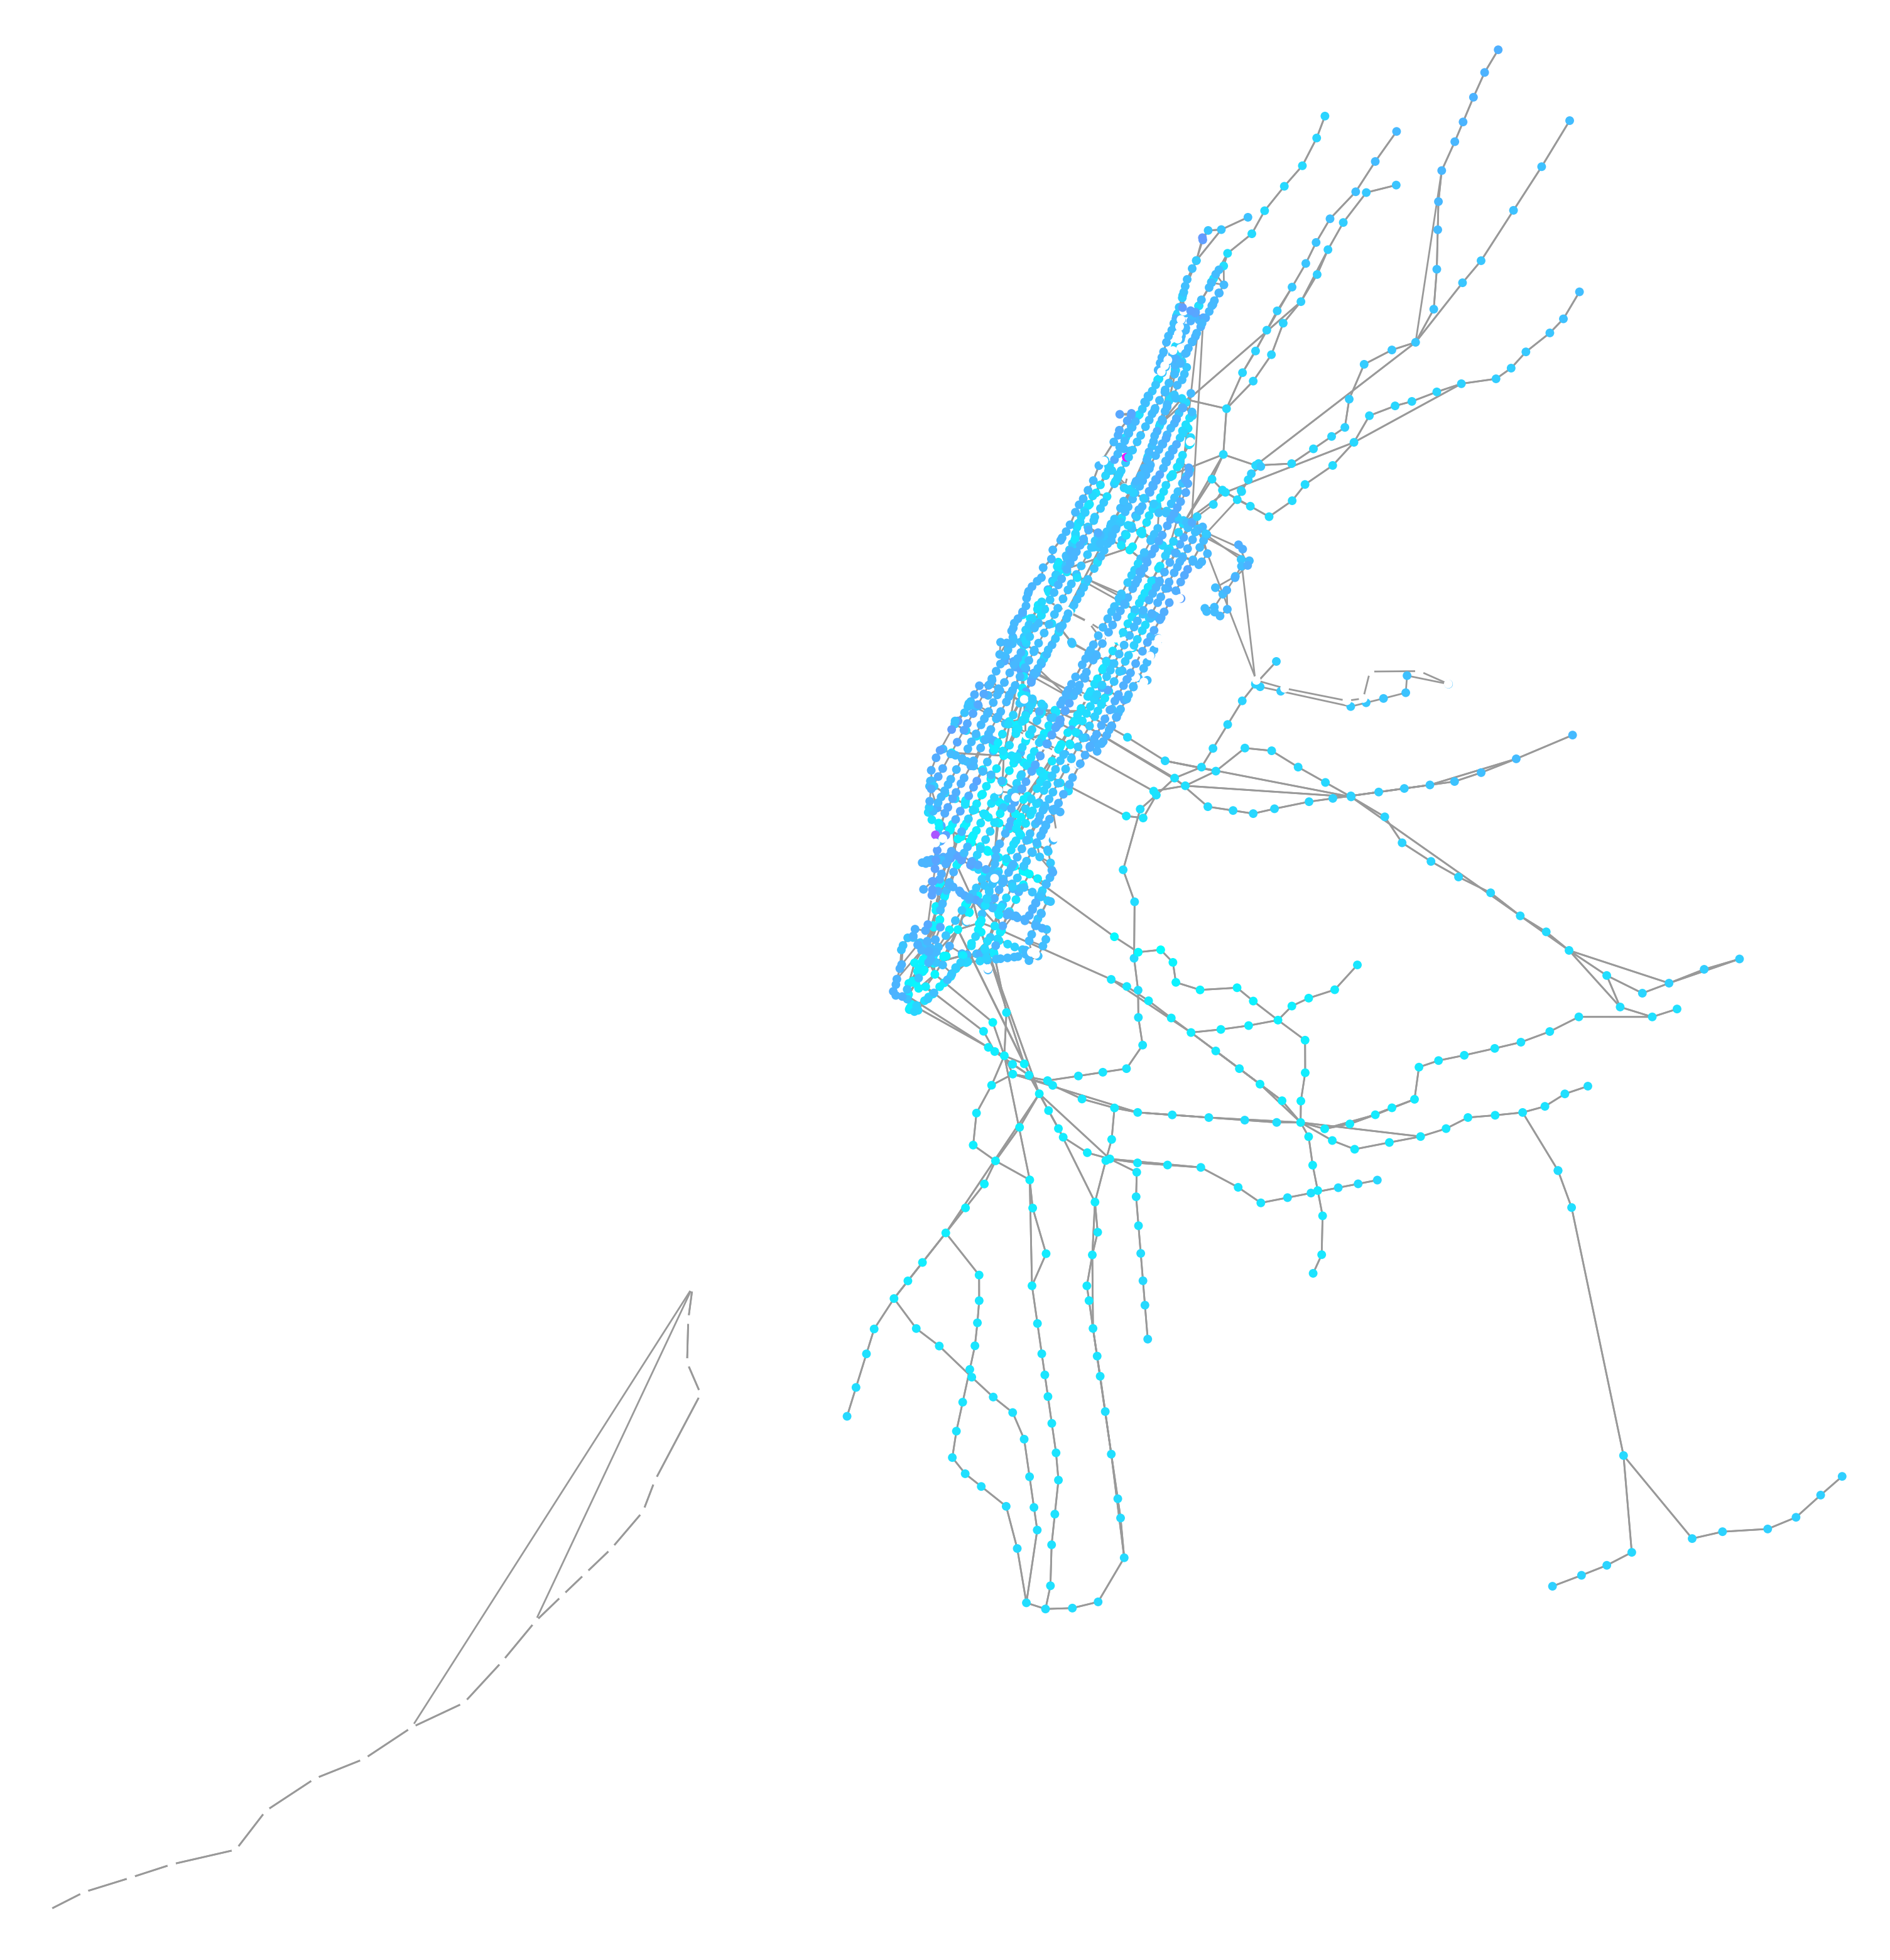

(<Figure size 2000x2000 with 1 Axes>, <Axes: >)

In [579]:
fig, ax = plt.subplots(figsize=(20,20))

ox.plot_graph(bike_and_subway, node_color=node_colors, ax=ax, node_size=25)
# plt.colorbar(ScalarMappable(
#     cmap='cool', 
#     norm=plt.Normalize(0, max_time)), 
#     label='travel time',
#     ax=ax
# )
# plt.show()

## Make service area polygons

In [580]:
bike_and_subway

In [588]:
# get all nodes accessible within n seconds

travel_times_from_origin = dict(map(lambda x: (x[0], x[1] - 0),filter(lambda x: x[1] != np.inf, sp.items())))

travel_times_from_origin

cutoff = 15 * 60 # 15 minutes
reachable = list(filter(lambda x: x[1] < cutoff, travel_times_from_origin.items()))
max(reachable, key=lambda x: x[1])

('L11N', 0)

In [589]:
travel_times_from_origin

{'101N': 13890.0,
 '103N': 13710.0,
 '104N': 12480.0,
 '106N': 12240.0,
 '107N': 12120.0,
 '108N': 12060.0,
 '109N': 10800.0,
 '110N': 10710.0,
 '111N': 10620.0,
 '112N': 10500.0,
 '113N': 10410.0,
 '114N': 10290.0,
 '115N': 9030.0,
 '116N': 8880.0,
 '117N': 8760.0,
 '118N': 7530.0,
 '119N': 7440.0,
 '120N': 6840.0,
 '121N': 7470.0,
 '227N': 7170.0,
 '123N': 5910.0,
 '122N': 7200.0,
 '226N': 8400.0,
 '124N': 5820.0,
 '127N': 5460.0,
 '225N': 8490.0,
 '125N': 5730.0,
 '128N': 5370.0,
 '126N': 5580.0,
 '901N': 7185.0,
 'D17N': 5670.0,
 'R15N': 9180.0,
 'R14N': 9390.0,
 '726N': 5700.0,
 '724N': 6030.0,
 'A25N': 6210.0,
 'A22N': 13110.0,
 'A27N': 7140.0,
 'A15N': 11070.0,
 'D14N': 5970.0,
 '129N': 5310.0,
 '132N': 3963.0,
 'A32N': 5640.0,
 'D16N': 7440.0,
 'D18N': 6450.0,
 'R18N': 5970.0,
 '635N': 2490.0,
 'R13N': 8760.0,
 'B08N': 9540.0,
 '631N': 6120.0,
 'A21N': 13200.0,
 'A28N': 7140.0,
 'A16N': 11250.0,
 'A14N': 13500.0,
 'A12N': 12390.0,
 'D15N': 7290.0,
 'F12N': 6330.0,
 'A20N': 1281

In [590]:
WALK_SPEED = 1.42 # m/s

# for each terminal node, the buffer will be the number of meters traveler can walk in their remaining time
# buffer = WALK_SPEED * (cutoff - Node time)
reachable_with_buffers = list(map(lambda x: (x[0], x[1], WALK_SPEED * (cutoff - x[1])), reachable))

reachable_with_buffers = pd.DataFrame(reachable_with_buffers, columns=['stop_id', 'time_to_node', 'buffer_at_node']).set_index("stop_id")
reachable_with_buffers

time_to_node  buffer_at_node
stop_id                              
L11N                0          1278.0

In [591]:
reachable_with_buffers = reachable_with_buffers.merge(
    ox.graph_to_gdfs(bike_and_subway, edges=False)[['geometry']],
    left_index=True,
    right_index=True,
    how='left'
)
# convert to gpd
reachable_with_buffers = gpd.GeoDataFrame(reachable_with_buffers, geometry='geometry', crs=3857)

reachable_with_buffers['buffered'] = reachable_with_buffers['geometry'].buffer(reachable_with_buffers['buffer_at_node'])

In [592]:
from shapely import unary_union
import contextily as cx

In [593]:
list(map(lambda x: x*60, range(10, 60, 10)))

[600, 1200, 1800, 2400, 3000]

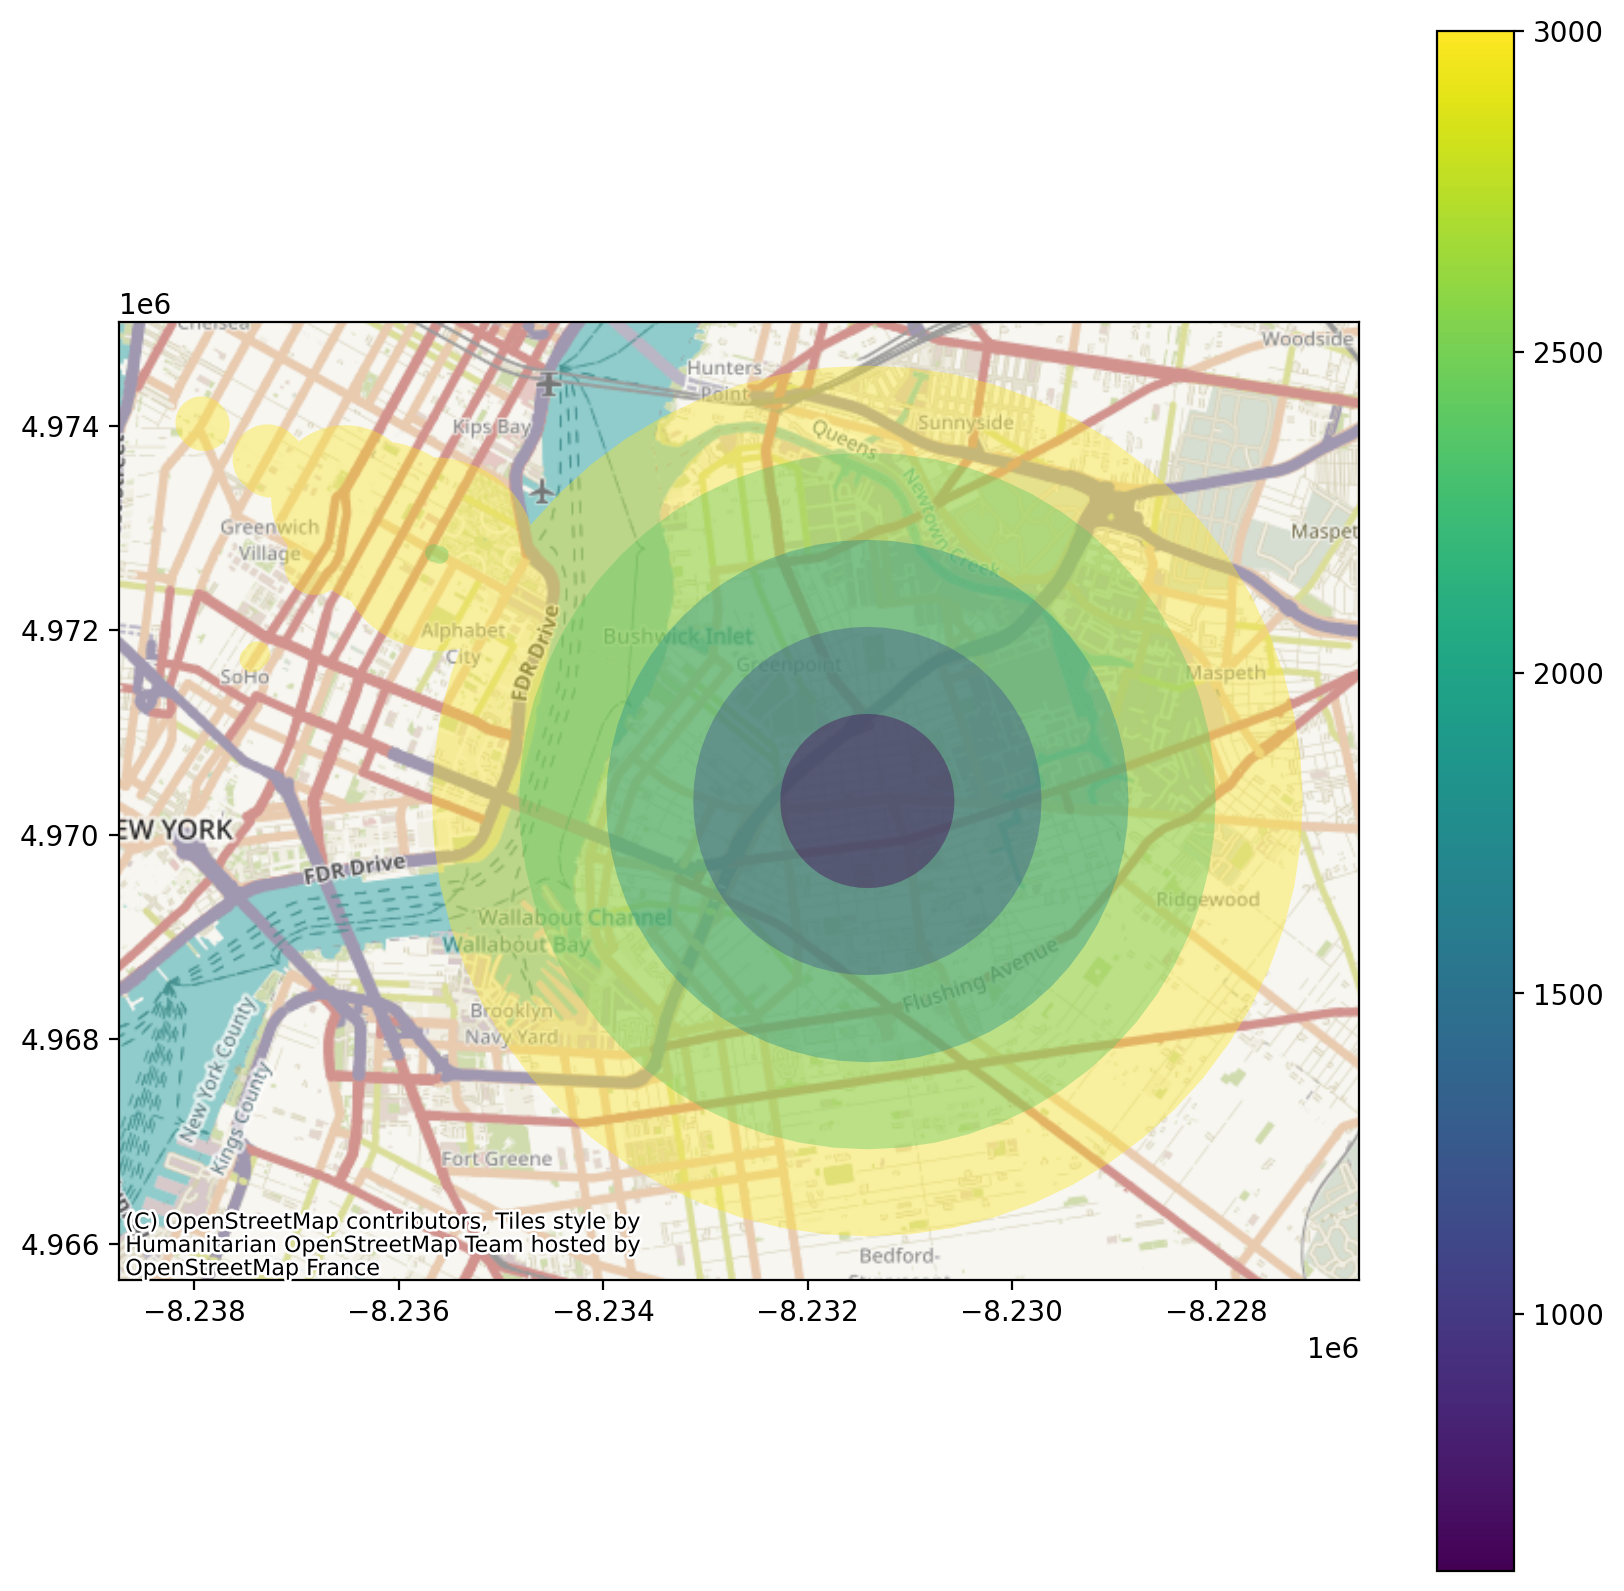

In [594]:
fig, ax = plt.subplots(figsize=(10,10))
transit_areas = msa.get_transit_areas(
    travel_times_from_origin, 
    list(map(lambda x: x*60, range(10, 60, 10))),
    ox.graph_to_gdfs(bike_and_subway, edges=False),
)
transit_areas = gpd.GeoDataFrame(
    transit_areas.sort_index(ascending=False)
).reset_index(drop=False).rename(columns={"index": "cutoffs", 0: "geometry"})
transit_areas = transit_areas.set_geometry('geometry')
transit_areas.plot(alpha=0.4, ax=ax, column='cutoffs', legend=True, cmap='viridis')
cx.add_basemap(ax)